In [1]:
import cv2
import numpy as np
import rawpy
import glob
import os
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# Implementazione OpenCV

In [2]:
# --- CONFIGURAZIONE ---
square_size = 20.0     # MODIFICA CON I TUOI MM
path_foto = './CRV Images Calibration/*.dng' 

# Prepara le coordinate 3D teoriche (0,0,0), (1,0,0), (2,0,0) ...
objp = np.zeros((5*8, 3), np.float32)
objp[:, :2] = np.mgrid[0:8, 0:5].T.reshape(-1, 2)
objp *= square_size

objpoints = [] # Punti 3D nello spazio reale
imgpoints = [] # Punti 2D nelle immagini

immagini = glob.glob(path_foto)

print(f"Trovate {len(immagini)} foto. Inizio analisi...")

for fname in immagini:
    with rawpy.imread(fname) as raw:
        # Sviluppo rapido per trovare gli angoli
        rgb = raw.postprocess(use_camera_wb=True, no_auto_bright=False)
        gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
        
        # Trova gli angoli della scacchiera
        ret, corners = cv2.findChessboardCorners(gray, (8, 5), None)
        
        if ret:
            objpoints.append(objp)
            # Affina la precisione degli angoli (Sub-pixel)
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imgpoints.append(corners2)

print(f"\nAnalisi completata. Foto valide: {len(imgpoints)} su {len(immagini)}")

# --- CALIBRAZIONE DI ZHANG ---
if len(imgpoints) > 20:
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, 
    imgpoints, 
    gray.shape[::-1], 
    None, 
    None
)
    
    print("\n--- RISULTATI CALIBRAZIONE ---")
    print("Matrice Intrinseca (K):\n", mtx)
    print("\nCoefficienti di Distorsione (D):\n", dist)
    print(f"\nErrore di riproiezione medio: {ret:.4f} pixel")
else:
    print("Errore: Troppe poche foto valide per calibrare.")

Trovate 40 foto. Inizio analisi...

Analisi completata. Foto valide: 40 su 40

--- RISULTATI CALIBRAZIONE ---
Matrice Intrinseca (K):
 [[3.88218252e+03 0.00000000e+00 2.26171591e+03]
 [0.00000000e+00 3.88350014e+03 1.61388815e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Coefficienti di Distorsione (D):
 [[-0.00075745 -0.21364659 -0.01415484  0.01240959  0.34239709]]

Errore di riproiezione medio: 5.4035 pixel


In [3]:
# 1. Otteniamo le dimensioni dall'immagine (es. la variabile 'gray' o 'rgb')
h, w = gray.shape[:2]
diagonale_pixel = np.sqrt(w**2 + h**2)

# 2. Parametri di calibrazione ottenuti
rms_assoluto = ret
focale_pixel = mtx[0, 0] # fx dalla Matrice K

# --- CALCOLO ERRORI RELATIVI ---

# A. Errore rispetto alla Diagonale (quanto "balla" il punto rispetto a tutta la foto)
errore_rel_diagonale = (rms_assoluto / diagonale_pixel) * 100

# B. Errore rispetto alla Focale (indica la precisione del modello angolare)
errore_rel_focale = (rms_assoluto / focale_pixel) * 100

print(f"Risoluzione immagine: {w}x{h} px")
print(f"Diagonale sensore: {diagonale_pixel:.2f} px")
print("-" * 30)
print(f"RMS Assoluto: {rms_assoluto:.4f} px")
print(f"Errore Relativo (su Diagonale): {errore_rel_diagonale:.4f}%")
print(f"Errore Relativo (su Focale):    {errore_rel_focale:.4f}%")

Risoluzione immagine: 4624x3472 px
Diagonale sensore: 5782.40 px
------------------------------
RMS Assoluto: 5.4035 px
Errore Relativo (su Diagonale): 0.0934%
Errore Relativo (su Focale):    0.1392%


# Implementazione Zhang Homemade

In [4]:
def carica_raw(path):
    with rawpy.imread(path) as raw:
        # Sviluppa l'immagine (postprocess)
        # use_camera_wb=True usa il bilanciamento del bianco del momento dello scatto
        # no_auto_bright=True evita che la luminosità cambi tra diverse foto
        rgb = raw.postprocess(use_camera_wb=True, no_auto_bright=False)
        
    # Converti da RGB (rawpy) a BGR (OpenCV)
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    return bgr

In [5]:
rows = 8
cols = 5
square_size = 20.0 # mm

# Liste per i dati
objpoints = [] # Punti 3D nel mondo reale
imgpoints = [] # Punti 2D nei pixel

def caricamento_punti(gray):
    objp = np.zeros((rows * cols, 3), np.float32)
    objp[:, :2] = np.mgrid[0:cols, 0:rows].T.reshape(-1, 2) * square_size
        
    # 1. Trova i corner (Livello Pixel)
    ret, corners = cv2.findChessboardCorners(gray, (cols, rows), None)

    if ret:
        # 2. Raffinamento Sub-pixel (FONDAMENTALE per Zhang)
        # Questo cerca il centro matematico dell'incrocio con precisione decimale
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            
        return objp, corners2

    return None, None


# top_5_images = [
#     './CRV Images Calibration/IMG_20260220_150504.dng', 
#     './CRV Images Calibration/IMG_20260220_145930.dng', 
#     './CRV Images Calibration/IMG_20260220_150511.dng', 
#     './CRV Images Calibration/IMG_20260220_150007.dng', 
#     './CRV Images Calibration/IMG_20260220_150401.dng' 
# ]
# images = top_5_images
images = glob.glob('./CRV Images Calibration/*.dng')

for fname in images:
    gray = carica_raw(fname)
    o, c = caricamento_punti(gray)
    if o is not None and c is not None:
        objpoints.append(o)
        imgpoints.append(c)
    else:
        print(f"Attenzione: Scacchiera non rilevata in {fname}. Salto questa immagine.")

print(f"Caricamento completato. Immagini valide: {len(objpoints)} su {len(images)}")

Caricamento completato. Immagini valide: 40 su 40


In [6]:
if len(objpoints[0]) != len(imgpoints[0]):
    raise Exception("Lenght doesnt match") 

In [7]:
def calcola_omografia_manuale(pts_world, pts_image):
    X_y_world = pts_world[:, :2]
    u_v_image = pts_image.reshape(-1, 2)
    
    A = []
    for i in range(len(X_y_world)):
        X, Y = X_y_world[i]
        u, v = u_v_image[i]
        
        A.append([-X, -Y, -1, 0, 0, 0, u*X, u*Y, u])
        A.append([0, 0, 0, -X, -Y, -1, v*X, v*Y, v])
    
    A = np.array(A)
    
    # Risolviamo il sistema lineare A * h = 0 usando la SVD (Singular Value Decomposition)
    _, _, Vh = np.linalg.svd(A)
    
    # La soluzione è l'ultimo autovettore (l'ultima riga di Vh)
    L = Vh[-1, :]
    
    # Rimodelliamo il vettore di 9 elementi in una matrice 3x3
    H = L.reshape(3, 3)
    
    # Normalizziamo la matrice dividendo per l'ultimo elemento H[2,2] 
    # per rendere la trasformazione canonica (H[2,2] = 1)
    if H[2, 2] != 0:
        H = H / H[2, 2]
        
    return H

In [8]:
h_list = []
for i in range(len(imgpoints)):
    H = calcola_omografia_manuale(objpoints[i], imgpoints[i])
    h_list.append(H)

In [9]:
print(h_list[0])

[[-2.11699572e-01 -1.29641294e+01  3.13366650e+03]
 [ 1.25485021e+01 -1.13813363e-01  1.25138564e+03]
 [-1.20876990e-04 -9.45338983e-05  1.00000000e+00]]


In [10]:
def get_v_vector(H, i, j):
    
    v = np.array([
        H[0,i]*H[0,j],
        H[0,i]*H[1,j] + H[1,i]*H[0,j],
        H[1,i]*H[1,j],
        H[2,i]*H[0,j] + H[0,i]*H[2,j],
        H[2,i]*H[1,j] + H[1,i]*H[2,j],
        H[2,i]*H[2,j]
    ])
    return v

In [11]:
V = []

for H in h_list:
    # Calcoliamo i tre vettori necessari per i due vincoli
    v12 = get_v_vector(H, 0, 1)
    v11 = get_v_vector(H, 0, 0)
    v22 = get_v_vector(H, 1, 1)
    
    # Vincolo 1: ortogonalità
    V.append(v12)
    
    # Vincolo 2: Scala
    V.append(v11 - v22)

# Trasformiamo la lista in una vera matrice NumPy
V = np.array(V)

print(f"Matrice V creata: {V.shape}") 

Matrice V creata: (80, 6)


In [12]:
_, _, Vh_b = np.linalg.svd(V)
b = Vh_b[-1, :]

print("Vettore b estratto:", b)

Vettore b estratto: [ 4.65962424e-08  9.47327360e-11  4.65024578e-08 -9.33867587e-05
 -7.68597617e-05  9.99999993e-01]


In [13]:
def estrai_parametri_intrinseci(b):
    # Estraiamo i singoli componenti per chiarezza secondo la notazione di Zhang
    B11, B12, B22, B13, B23, B33 = b
    
    # Formule di Zhang per estrarre i parametri della matrice K
    v0 = (B12 * B13 - B11 * B23) / (B11 * B22 - B12**2)
    lambda_ = B33 - (B13**2 + v0 * (B12 * B13 - B11 * B23)) / B11
    alpha = np.sqrt(lambda_ / B11)
    beta = np.sqrt(lambda_ * B11 / (B11 * B22 - B12**2))
    gamma = -B12 * alpha**2 * beta / lambda_
    u0 = gamma * v0 / beta - B13 * alpha**2 / lambda_
    
    K = np.array([
        [alpha, gamma, u0],
        [0,     beta,  v0],
        [0,     0,     1]
    ])
    
    return K

K_finale = estrai_parametri_intrinseci(b)
print("Matrice Intrinseca K:\n", K_finale)

Matrice Intrinseca K:
 [[ 3.83815311e+03 -7.81105820e+00  2.00081734e+03]
 [ 0.00000000e+00  3.84202945e+03  1.64873476e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [14]:
def estrai_K_cholesky(b):

    # 1. Ricostruiamo la matrice simmetrica B
    B = np.array([
        [b[0], b[1], b[3]],
        [b[1], b[2], b[4]],
        [b[3], b[4], b[5]]
    ])
    
    # Controllo di positività (fondamentale per la radice quadrata)
    # Se il determinante è negativo, invertiamo il segno
    if np.linalg.det(B) < 0:
        B = -B
    
    # Decomposizione di Cholesky: B = L * L^T
    L = np.linalg.cholesky(B)
    K_inv = L.T
        
    # 4. Calcoliamo K invertendo K_inv
    K = np.linalg.inv(K_inv)
        
    # 5. Normalizziamo affinché l'ultimo elemento sia 1
    K /= K[2, 2]
        
        
    return K

K_finale = estrai_K_cholesky(b)
print(K_finale)

[[ 3.83815311e+03 -7.81105820e+00  2.00081734e+03]
 [ 0.00000000e+00  3.84202945e+03  1.64873476e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [15]:
def estrai_estrinseci(H, K):
    K_inv = np.linalg.inv(K)
    
    # Estraiamo le colonne
    h1 = H[:, 0]
    h2 = H[:, 1]
    h3 = H[:, 2]
    
    # Calcoliamo il fattore di scala (lambda)
    # se usassimo h2 ci aspetteremmo lo stesso valore
    lamba = 1 / np.linalg.norm(K_inv @ h1)
    
    # 4. Costruiamo i vettori di rotazione
    r1 = lamba * (K_inv @ h1)
    r2 = lamba * (K_inv @ h2)
    r3 = np.cross(r1, r2)
    
    # Costruiamo la matrice di rotazione R = [r1, r2, r3]
    R_raw = np.stack((r1, r2, r3), axis=1)
    
    # SVD
    # Una matrice di rotazione deve essere ortogonale (R^T * R = I)
    U, S, Vh = np.linalg.svd(R_raw)
    R = U @ Vh
    
    # 8. Traslazione finale
    t = lamba * (K_inv @ h3)
    
    return R, t

R_list = []
t_list = []
for H in h_list:
    R, t = estrai_estrinseci(H, K_finale)
    R_list.append(R)
    t_list.append(t)

In [16]:
def funzione_errore(params, objpoints, imgpoints, K, R_list, t_list):
    # Recuperiamo tutti e 5 i parametri
    k1, k2, p1, p2, k3 = params
    errori = []
    
    for i in range(len(imgpoints)):
        R = R_list[i]
        t = t_list[i].reshape(3, 1)
        
        # 1. Trasformiamo i punti 3D in coordinate camera
        pts_3d = objpoints[i] 
        pts_cam = (R @ pts_3d.T + t).T
        
        # 2. Coordinate normalizzate (x, y)
        x = pts_cam[:, 0] / pts_cam[:, 2]
        y = pts_cam[:, 1] / pts_cam[:, 2]
        
        # Sviluppi Taylor per disotrsione lente
        r2 = x**2 + y**2
        r4 = r2**2
        r6 = r2**3 # Necessario per k3 (fondamentale per grandangoli)
        
        # 3. Modello di distorsione Brown-Conrady (Radiale + Tangenziale)
        # Parte radiale: agisce sulla "pancia" dell'immagine
        rad = (1 + k1*r2 + k2*r4 + k3*r6)
        
        # Parte tangenziale: corregge l'eventuale inclinazione lente/sensore
        x_tang = 2 * p1 * x * y + p2 * (r2 + 2 * x**2)
        y_tang = p1 * (r2 + 2 * y**2) + 2 * p2 * x * y
        
        x_d = x * rad + x_tang
        y_d = y * rad + y_tang
        
        # 4. Trasformiamo in pixel usando K
        u_proj = K[0,0] * x_d + K[0,2]
        v_proj = K[1,1] * y_d + K[1,2]
        
        # 5. Calcoliamo lo scostamento dai pixel reali (imgpoints)
        err_x = u_proj - imgpoints[i][:, 0, 0]
        err_y = v_proj - imgpoints[i][:, 0, 1]
        
        errori.extend(err_x)
        errori.extend(err_y)
        
    return np.array(errori)

# --- Esecuzione dell'ottimizzazione ---
# Partiamo da zero per tutti e 5 i parametri
x0_iniziali = [0, 0, 0, 0, 0]

res = least_squares(funzione_errore, x0=x0_iniziali, args=(objpoints, imgpoints, K_finale, R_list, t_list))

# Estraiamo i risultati
k1_ott, k2_ott, p1_ott, p2_ott, k3_ott = res.x

print("Coefficienti di distorsione ottimizzati:")
print(f"Radiali: k1={k1_ott:.6f}, k2={k2_ott:.6f}, k3={k3_ott:.6f}")
print(f"Tangenziali: p1={p1_ott:.6f}, p2={p2_ott:.6f}")

Coefficienti di distorsione ottimizzati:
Radiali: k1=-0.214949, k2=1.197402, k3=-1.823834
Tangenziali: p1=-0.003823, p2=-0.001377


In [17]:
errori_finali = funzione_errore(res.x, objpoints, imgpoints, K_finale, R_list, t_list)
rmse = np.sqrt(np.mean(errori_finali**2))
print(f"Errore medio di riproiezione: {rmse:.4f} pixel")

Errore medio di riproiezione: 31.3460 pixel


In [18]:
def pixel_to_world_coords(u, v, K, dist_coeffs, R, t, altezza_oggetto=0):
    """
    Calcola le coordinate reali (X, Y) in mm di un pixel (u, v)
    intersecando il raggio ottico con un piano parallelo alla scacchiera
    posto ad una altezza Z = altezza_oggetto.
    """
    # Raddrizziamo il punto (Undistort dei singoli pixel)
    pts = np.array([[[u, v]]], dtype=np.float32)
    # Ritorna le coordinate normalizzate (x, y) sul piano a distanza focale 1
    pts_undistorted = cv2.undistortPoints(pts, K, dist_coeffs)
    x_norm, y_norm = pts_undistorted[0][0]

    # Raggio nel sistema camera (Z=1)
    p_cam = np.array([x_norm, y_norm, 1.0])

    # Trasformazione nel sistema Mondo
    R_inv = R.T
    # Punto proiettato a distanza focale 1 nel mondo
    p_world = R_inv @ (p_cam - t.flatten())
    # Centro ottico della camera nel mondo (punto di origine del raggio)
    C_world = R_inv @ (-t.flatten())
    
    # Intersezione con il piano Z = altezza_oggetto
    w = (altezza_oggetto - C_world[2]) / (p_world[2] - C_world[2])
    
    X_final = C_world[0] + w * (p_world[0] - C_world[0])
    Y_final = C_world[1] + w * (p_world[1] - C_world[1])
    
    return np.array([X_final, Y_final, altezza_oggetto])

def calcola_distanza_reale_3d(p1_pix, p2_pix, K, dist_coeffs, R, t, w):

    p1_world = pixel_to_world_coords(p1_pix[0], p1_pix[1], K, dist_coeffs, R, t, w)
    p2_world = pixel_to_world_coords(p2_pix[0], p2_pix[1], K, dist_coeffs, R, t, w)
    
    distanza = np.linalg.norm(p1_world - p2_world)
    return distanza

In [19]:
# --- Configurazione Iniziale ---
path_raw = './CRV Images Misure/IMG_20260222_170432.dng'
altezza_oggetto = 0 # Altezza da inserire in negativo per come opencv ha messo il sistema di riferimento
immagine_originale = carica_raw(path_raw)
world_pts, image_pts = caricamento_punti(immagine_originale)
hom = calcola_omografia_manuale(world_pts, image_pts)
r_img, t_img = estrai_estrinseci(hom, K_finale)

dist_coeffs = np.array([k1_ott, k2_ott, p1_ott, p2_ott, k3_ott], dtype=np.float32)

# Se l'immagine è troppo grande per lo schermo, calcoliamo un fattore di scala
# ATTENZIONE: i click del mouse devono essere moltiplicati per l'inverso 
# di questo fattore per corrispondere ai pixel reali usati in K
resize_factor = 0.3 
h, w = immagine_originale.shape[:2]
img_display = cv2.resize(immagine_originale, (int(w*resize_factor), int(h*resize_factor)))

punti_cliccati = []

def click_event(event, x, y, flags, params):
    if event == cv2.EVENT_LBUTTONDOWN:
        # Riportiamo le coordinate x, y alla risoluzione originale del RAW
        x_real = x / resize_factor
        y_real = y / resize_factor
        
        punti_cliccati.append((x_real, y_real))
        print(f"Punto selezionato (coord. RAW): ({x_real:.1f}, {y_real:.1f})")
        
        if len(punti_cliccati) == 2:
            # Qui usiamo la tua funzione calcola_distanza_reale_3d
            # Assicurati che K, dist_coeffs, R e t siano quelli riferiti alla risoluzione piena del RAW
            d = calcola_distanza_reale_3d(punti_cliccati[0], punti_cliccati[1], 
                                          K_finale, dist_coeffs, r_img, t_img, w=altezza_oggetto) 
            print(f"\n[RISULTATO] Distanza misurata: {d:.2f} mm\n")
            punti_cliccati.clear()

# Visualizza l'immagine ridimensionata per il monitor
cv2.imshow('Righello Virtuale (RAW)', img_display)
cv2.setMouseCallback('Righello Virtuale (RAW)', click_event)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [20]:
def analizza_errori_per_foto(params, objpoints, imgpoints, K, R_list, t_list, file_list):
    k1, k2, p1, p2, k3 = params
    report_errori = []
    
    for i in range(len(imgpoints)):
        R = R_list[i]
        t = t_list[i].reshape(3, 1)
        
        # Proiezione punti
        pts_3d = objpoints[i]
        pts_cam = (R @ pts_3d.T + t).T
        x = pts_cam[:, 0] / pts_cam[:, 2]
        y = pts_cam[:, 1] / pts_cam[:, 2]
        
        r2 = x**2 + y**2
        rad = (1 + k1*r2 + k2*r2**2 + k3*r2**3)
        x_tang = 2*p1*x*y + p2*(r2 + 2*x**2)
        y_tang = p1*(r2 + 2*y**2) + 2*p2*x*y
        
        x_d = x * rad + x_tang
        y_d = y * rad + y_tang
        
        u_proj = K[0,0] * x_d + K[0,2]
        v_proj = K[1,1] * y_d + K[1,2]
        
        # Calcolo errore Euclideo medio per questa specifica foto
        distanze = np.sqrt((u_proj - imgpoints[i][:, 0, 0])**2 + 
                           (v_proj - imgpoints[i][:, 0, 1])**2)
        errore_medio_foto = np.mean(distanze)
        
        # Recuperiamo il nome del file dal percorso completo
        nome_file = os.path.basename(file_list[i])
        
        report_errori.append((i, errore_medio_foto, nome_file))
    
    # Ordina per errore
    report_errori.sort(key=lambda x: x[1])
    return report_errori

# Esecuzione (passando la variabile 'images' che contiene i nomi dei file .dng)
classifica = analizza_errori_per_foto(res.x, objpoints, imgpoints, K_finale, R_list, t_list, images)

print(f"{'ID':<5} | {'Errore (px)':<12} | {'Nome File'}")
print("-" * 50)

print("--- TOP 5 FOTO (Le più precise) ---")
for i in range(min(5, len(classifica))):
    idx, err, nome = classifica[i]
    print(f"{idx:<5} | {err:<12.2f} | {nome}")

print("\n--- PEGGIORI 5 FOTO (Da controllare/scartare) ---")
for i in range(-1, -6, -1):
    if abs(i) <= len(classifica):
        idx, err, nome = classifica[i]
        print(f"{idx:<5} | {err:<12.2f} | {nome}")

ID    | Errore (px)  | Nome File
--------------------------------------------------
--- TOP 5 FOTO (Le più precise) ---
36    | 2.37         | IMG_20260220_150504.dng
0     | 6.78         | IMG_20260220_145930.dng
37    | 8.47         | IMG_20260220_150511.dng
5     | 10.40        | IMG_20260220_150007.dng
29    | 11.19        | IMG_20260220_150401.dng

--- PEGGIORI 5 FOTO (Da controllare/scartare) ---
27    | 94.14        | IMG_20260220_150331.dng
16    | 72.78        | IMG_20260220_150131.dng
9     | 62.79        | IMG_20260220_150035.dng
23    | 61.36        | IMG_20260220_150245.dng
33    | 59.71        | IMG_20260220_150442.dng


# FishEye Test

In [21]:
def applica_fish_eye_effect(img, k=0.7):
    h, w = img.shape[:2]
    
    # 1. Definiamo i parametri intrinseci virtuali per il fisheye
    # Una focale corta (es. w/2) accentua l'effetto grandangolo
    f = w / 2
    K = np.array([[f, 0, w/2], 
                  [0, f, h/2], 
                  [0, 0, 1]], dtype=np.float32)
    
    # 2. Parametri di distorsione fisheye (k1, k2, k3, k4)
    D = np.array([k, k, 0, 0], dtype=np.float32)
    
    # 3. Creiamo la griglia di pixel dell'immagine
    # Dobbiamo sapere dove ogni pixel "vorrebbe" andare
    map_x, map_y = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, (w, h), cv2.CV_32FC1)
    
    # Invertiamo il senso: invece di raddrizzare, distorciamo
    # (cv2.fisheye lavora solitamente per correggere, quindi usiamo remap per deformare)
    img_distorta = cv2.remap(img, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    return img_distorta

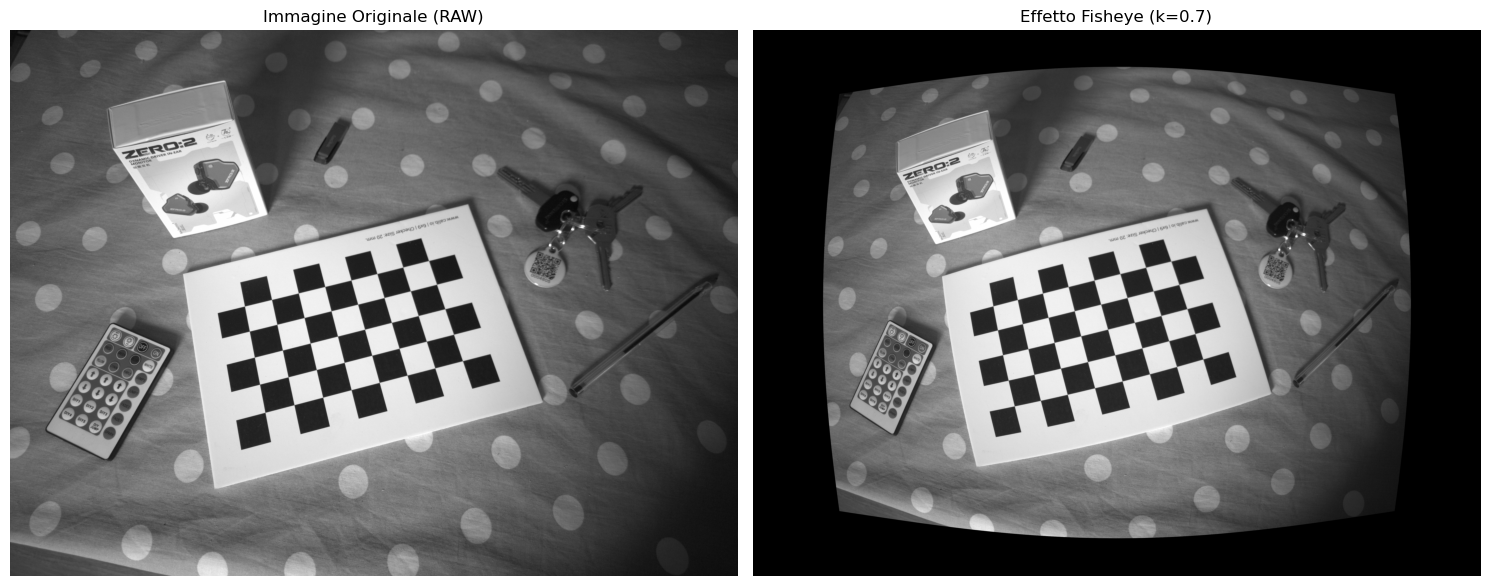

In [22]:
def mostra_confronto_fisheye(img):
    k = 0.7
    img_distorta = applica_fish_eye_effect(img, k)
    # 4. Visualizzazione con Matplotlib (molto meglio per i RAW grandi rispetto a imshow)
    plt.figure(figsize=(15, 7))
    
    plt.subplot(1, 2, 1)
    plt.title("Immagine Originale (RAW)")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title(f"Effetto Fisheye (k={k})")
    plt.imshow(img_distorta, cmap='gray')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Esempio d'uso:
img_raw = carica_raw('./CRV Images Misure/IMG_20260222_170432.dng')
mostra_confronto_fisheye(img_raw)

In [23]:
objpoints_fe = []
imgpoints_fe = []

images_fe = glob.glob('./CRV Images Calibration/*.dng')
for fname in images_fe:
    gray = carica_raw(fname)
    gray_fe = applica_fish_eye_effect(gray, 0.7)
    o, c = caricamento_punti(gray_fe)
    if o is not None and c is not None:
        objpoints_fe.append(o)
        imgpoints_fe.append(c)
    else:
        print(f"Attenzione: Scacchiera non rilevata in {fname}. Salto questa immagine.")

print(f"Caricamento completato. Immagini valide: {len(objpoints_fe)} su {len(images_fe)}")

Attenzione: Scacchiera non rilevata in ./CRV Images Calibration\IMG_20260220_150349.dng. Salto questa immagine.
Caricamento completato. Immagini valide: 39 su 40


In [24]:
h_list_fe = []
for i in range(len(imgpoints_fe)):
    H = calcola_omografia_manuale(objpoints_fe[i], imgpoints_fe[i])
    h_list_fe.append(H)

In [25]:
V_fe = []

for H in h_list_fe:
    # Calcoliamo i tre vettori necessari per i due vincoli
    v12 = get_v_vector(H, 0, 1)
    v11 = get_v_vector(H, 0, 0)
    v22 = get_v_vector(H, 1, 1)
    
    # Vincolo 1: ortogonalità
    V_fe.append(v12)
    
    # Vincolo 2: Scala
    V_fe.append(v11 - v22)

# Trasformiamo la lista in una vera matrice NumPy
V_fe = np.array(V_fe)

print(f"Matrice V creata: {V_fe.shape}")

Matrice V creata: (78, 6)


In [26]:
_, _, Vh_b_fe = np.linalg.svd(V_fe)
b_fe = Vh_b_fe[-1, :]

print("Vettore b estratto:", b_fe)

Vettore b estratto: [ 5.55993180e-08 -1.16600409e-10  5.44418257e-08 -1.17869268e-04
 -9.25006355e-05  9.99999989e-01]


In [27]:
K_finale_fe = estrai_K_cholesky(b_fe)
print(K_finale_fe)

[[3.26337861e+03 6.91619833e+00 2.12354962e+03]
 [0.00000000e+00 3.29789504e+03 1.70362109e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [28]:
R_list_fe = []
t_list_fe = []
for H in h_list_fe:
    R_fe, t_fe = estrai_estrinseci(H, K_finale_fe)
    R_list_fe.append(R_fe)
    t_list_fe.append(t_fe)

In [29]:
res_fe = least_squares(funzione_errore, x0=x0_iniziali, args=(objpoints_fe, imgpoints_fe, K_finale_fe, R_list_fe, t_list_fe))

# Estraiamo i risultati
k1_ott_fe, k2_ott_fe, p1_ott_fe, p2_ott_fe, k3_ott_fe = res_fe.x

print("Coefficienti di distorsione ottimizzati FE Effect:")
print(f"Radiali: k1={k1_ott_fe:.6f}, k2={k2_ott_fe:.6f}, k3={k3_ott_fe:.6f}")
print(f"Tangenziali: p1={p1_ott_fe:.6f}, p2={p2_ott_fe:.6f}")

Coefficienti di distorsione ottimizzati FE Effect:
Radiali: k1=-0.258487, k2=1.306889, k3=-2.647987
Tangenziali: p1=-0.009688, p2=0.009071


In [30]:
errori_finali_fe = funzione_errore(res_fe.x, objpoints_fe, imgpoints_fe, K_finale_fe, R_list_fe, t_list_fe)
rmse_fe = np.sqrt(np.mean(errori_finali_fe**2))
print(f"Errore medio di riproiezione FE Effect: {rmse_fe:.4f} pixel")

Errore medio di riproiezione FE Effect: 50.4047 pixel


In [31]:
# --- Configurazione Iniziale ---
path_raw = './CRV Images Misure/IMG_20260222_170432.dng'
altezza_oggetto = 0 # Altezza da inserire in negativo per come opencv ha messo il sistema di riferimento
immagine_originale = carica_raw(path_raw)
immagine_fe = applica_fish_eye_effect(immagine_originale, 0.7)
world_pts_fe, image_pts_fe = caricamento_punti(immagine_fe)
hom_fe = calcola_omografia_manuale(world_pts_fe, image_pts_fe)
r_img_fe, t_img_fe = estrai_estrinseci(hom_fe, K_finale_fe)

dist_coeffs_fe = np.array([k1_ott_fe, k2_ott_fe, p1_ott_fe, p2_ott_fe, k3_ott_fe], dtype=np.float32)

# Se l'immagine è troppo grande per lo schermo, calcoliamo un fattore di scala
# ATTENZIONE: i click del mouse devono essere moltiplicati per l'inverso 
# di questo fattore per corrispondere ai pixel reali usati in K
h, w = immagine_originale.shape[:2]
img_display = cv2.resize(immagine_originale, (int(w*resize_factor), int(h*resize_factor)))

punti_cliccati_fe = []

def click_event_fe(event, x, y, flags, params):
    if event == cv2.EVENT_LBUTTONDOWN:
        # Riportiamo le coordinate x, y alla risoluzione originale del RAW
        x_real = x / resize_factor
        y_real = y / resize_factor
        
        punti_cliccati_fe.append((x_real, y_real))
        print(f"Punto selezionato (coord. RAW): ({x_real:.1f}, {y_real:.1f})")
        
        if len(punti_cliccati_fe) == 2:
            # Qui usiamo la tua funzione calcola_distanza_reale_3d
            # Assicurati che K, dist_coeffs, R e t siano quelli riferiti alla risoluzione piena del RAW
            d = calcola_distanza_reale_3d(punti_cliccati_fe[0], punti_cliccati_fe[1], 
                                          K_finale_fe, dist_coeffs_fe, r_img_fe, t_img_fe, w=altezza_oggetto) 
            print(f"\n[RISULTATO] Distanza misurata: {d:.2f} mm\n")
            punti_cliccati_fe.clear()

# Visualizza l'immagine ridimensionata per il monitor
cv2.imshow('Righello Virtuale (RAW)', img_display)
cv2.setMouseCallback('Righello Virtuale (RAW)', click_event_fe)
cv2.waitKey(0)
cv2.destroyAllWindows()